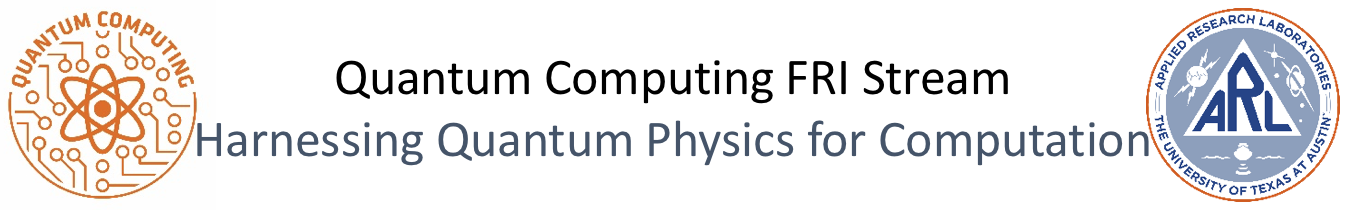

# Oracle Building
## Lesson 7

### Installations and Imports

In [ ]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import numpy as np
import random
from random import choice
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector



### <font color=green>TEST CASE GENERATOR FOR TESTING</font>


In [ ]:
#Test Case Generator For Testing
num_cases = 1
for i in range(num_cases):
  n_clauses = random.randint(1,5)
  num_var = random.randint(3, n_clauses*3)

  var_order = []
  for x in range(n_clauses):
    cur_list = []
    for y in range(3):
      cur_list.append(choice([q for q in range(num_var) if q not in cur_list]))
    for yy in range(3):
      var_order.append(cur_list[yy])

  cur_str = ""
  for j in range(n_clauses):
    cur_str += "("
    for k in range(3):
      comp = random.randint(0,1)
      if comp == 0:
        cur_str += "!"
      cur_str += str("x" + str(var_order.pop(0)))
      if k < 2:
        cur_str += " | "
      else:
        cur_str += ")"
        if j < n_clauses - 1:
          cur_str += " & "

  print(cur_str)

(!x3 | x0 | !x2) & (!x0 | x2 | !x1) & (x5 | x2 | x3)




### <font color=green>INPUT EXPRESSION HERE</font>

Add your input to the box below by changing the value of the "real_input" variable

In [ ]:
real_input = ""

""" The following is for demonstration purposes
demo = "(A | B | C) & (A | B | !C) & (A | !B | C) & (A | !B | !C) & (!A | B | C) & (!A | B | !C) & (!A | !B | C)" # 1 solution
demo2 = "(!v_1 | !v_2 | !v_3) & (v_1 | !v_2 | v_3) & (v_1 | v_2 | !v_3) & (v_1 | !v_2 | !v_3) & (!v_1 | v_2 | v_3)" #3 solutions
#real_input = "(!x2 | !x1 | !x4) & (x1 | x5 | !x4) & (!x5 | !x2 | x3)"
#real_input = "(x1 | x0 | !x3) & (!x2 | !x3 | !x1)"
real_input = demo2
"""
print(real_input)

(!v_1 | !v_2 | !v_3) & (v_1 | !v_2 | v_3) & (v_1 | v_2 | !v_3) & (v_1 | !v_2 | !v_3) & (!v_1 | v_2 | v_3)




### <font color=green>CLASSIC SAT SOLVER METHODS</font>

In [ ]:
def bool_recurse(n,i,values,clauses):
  if i == n:
    val = solve_bool(clauses)
    if val==True:
      bitstr = ""
      for j in range(len(values)):
        bitstr+=str(int(values[j]))
      global classical_answers
      classical_answers.add(bitstr)
      return 1
    else:
      return 0
  total = 0
  values[i]=False
  total += bool_recurse(n,i+1,values,clauses)
  values[i]=True
  total += bool_recurse(n,i+1,values,clauses)
  return total

def solve_bool(clauses):
  clause_list = [0 for x in range(len(clauses))]
  for j in range(len(clauses)):
    vars = clauses[j].split(" | ")
    ans = False
    for i in vars:
      var_name = i
      if(i[0]=='!'):
        var_name = i[1:len(i)]
      var_val = var_list[var_index[var_name]]
      if(i[0]=='!'):
        var_val = not var_val
      ans = ans or var_val
    clause_list[j] = ans
  final_answer = True
  for val in clause_list:
    final_answer = final_answer and val
  return final_answer



### <font color=green>ORACLE MAKER FUNCTIONS</font>


In [ ]:
##function file
qubit_dict = {}

def parse_clause_str(input):
    arr = input.split(' ')
    if len(arr) != 5:
      raise Exception("Input invalid")
    return arr

def apply_and(qc, aux, input, temp, i1, i2):
    qc.ccx(input[i1], input[i2], temp)

def apply_or(qc, aux, input, temp, i1, i2):
    qc.x(input[i1])
    qc.x(input[i2])
    qc.x(temp)
    qc.ccx(input[i1], input[i2], temp)
    qc.x(input[i1])
    qc.x(input[i2])

def apply_or_2(qc, aux, input, temp, i1, i2):
    qc.x(temp)
    qc.x(input[i1])
    qc.x(aux[i2])
    qc.ccx(input[i1], temp, aux[i2])
    qc.x(temp)
    qc.x(input[i1])

def apply_or_undo(qc, aux, input, temp, i1, i2):
    qc.x(input[i1])
    qc.x(input[i2])
    qc.ccx(input[i1], input[i2], temp)
    qc.x(temp)
    qc.x(input[i1])
    qc.x(input[i2])

def apply_or_2_undo(qc, aux, input, temp, i1, i2):
    qc.x(temp)
    qc.x(input[i1])

    qc.ccx(input[i1], temp, aux[i2])
    qc.x(aux[i2])
    qc.x(temp)
    qc.x(input[i1])

def apply_and_2(qc, aux, input, temp, i1, i2):
    qc.ccx(input[i1], temp, aux[i2])

def complement(qc, input, arr):
    #apply nots
    temp = [arr[0].replace('!', ''), arr[2].replace('!', ''), arr[4].replace('!', '')]
    if (arr[0])[0] == '!':
        qc.x(input[qubit_dict[temp[0]]])
    if (arr[2])[0] == '!':
        qc.x(input[qubit_dict[temp[1]]])  
    if (arr[4])[0] == '!':
        qc.x(input[qubit_dict[temp[2]]])  

def count_input(real):
    result = real.replace('(', '')
    result = result.replace(')', '')
    result = result.replace('!', '')
    result = result.replace('|', '')
    result = result.replace('&', '')
    temp = result.split()

    res = []
    [res.append(x) for x in temp if x not in res]

    for i in range(len(res)):
        if res[i] not in qubit_dict.keys():
            qubit_dict[res[i]] = i
    return len(qubit_dict)

def parse_real(real):
    result = real.replace('(', '')
    result = result.replace(')', '')
    arr = result.split(' & ')
    return arr

def apply_clause(input_str, qc, aux, input, temp, index):

    arr = parse_clause_str(input_str)
    names = [arr[0].replace('!', ''), arr[2].replace('!', ''), arr[4].replace('!', '')]

    if len(qubit_dict) <= 0:
      raise Exception("invalid input")
    if len(names) != 3:
      raise Exception("invalid input")

    complement(qc, input, arr)
    qc.barrier()

    #apply and/or on first 2 terms
    if arr[1] == '|':
        apply_or(qc, aux, input, temp, qubit_dict[names[0]], qubit_dict[names[1]])
    else:
        raise Exception("clause operator must be an |") #VALIDATES INPUT
    qc.barrier()

    #apply and/or on result and 3rd term
    if arr[3] == '|':
        apply_or_2(qc, aux, input, temp, qubit_dict[names[2]], index)
    else:
        raise Exception("clause operator must be an |") #VALIDATES INPUT
    qc.barrier()

    #uncompute the computations
    if arr[1] == '|':
        apply_or_undo(qc, aux, input, temp, qubit_dict[names[0]], qubit_dict[names[1]])
    else:
        raise Exception("clause operator must be an |") #VALIDATES INPUT
    qc.barrier()
    
    #undo the complements
    complement(qc, input, arr)

def apply_clause_rev(input_str, qc, aux, input, temp, index):
    #assert len(qubit_dict) > 0

    arr = parse_clause_str(input_str)
    names = [arr[0].replace('!', ''), arr[2].replace('!', ''), arr[4].replace('!', '')]

    complement(qc, input, arr)
    qc.barrier()

    #apply and/or on first 2 terms
    if arr[1] == '|':
        apply_or(qc, aux, input, temp, qubit_dict[names[0]], qubit_dict[names[1]])
    qc.barrier()

    #apply and/or on result and 3rd term
    if arr[3] == '|':
        apply_or_2_undo(qc, aux, input, temp, qubit_dict[names[2]], index)
    qc.barrier()

    #uncompute the computations
    if arr[1] == '|':
        apply_or_undo(qc, aux, input, temp, qubit_dict[names[0]], qubit_dict[names[1]])
    qc.barrier()
    
    #undo the complements
    complement(qc, input, arr)



### <font color=green>RUN THIS CELL TO CREATE ORACLE</font>


{'v_1': 0, 'v_2': 1, 'v_3': 2}


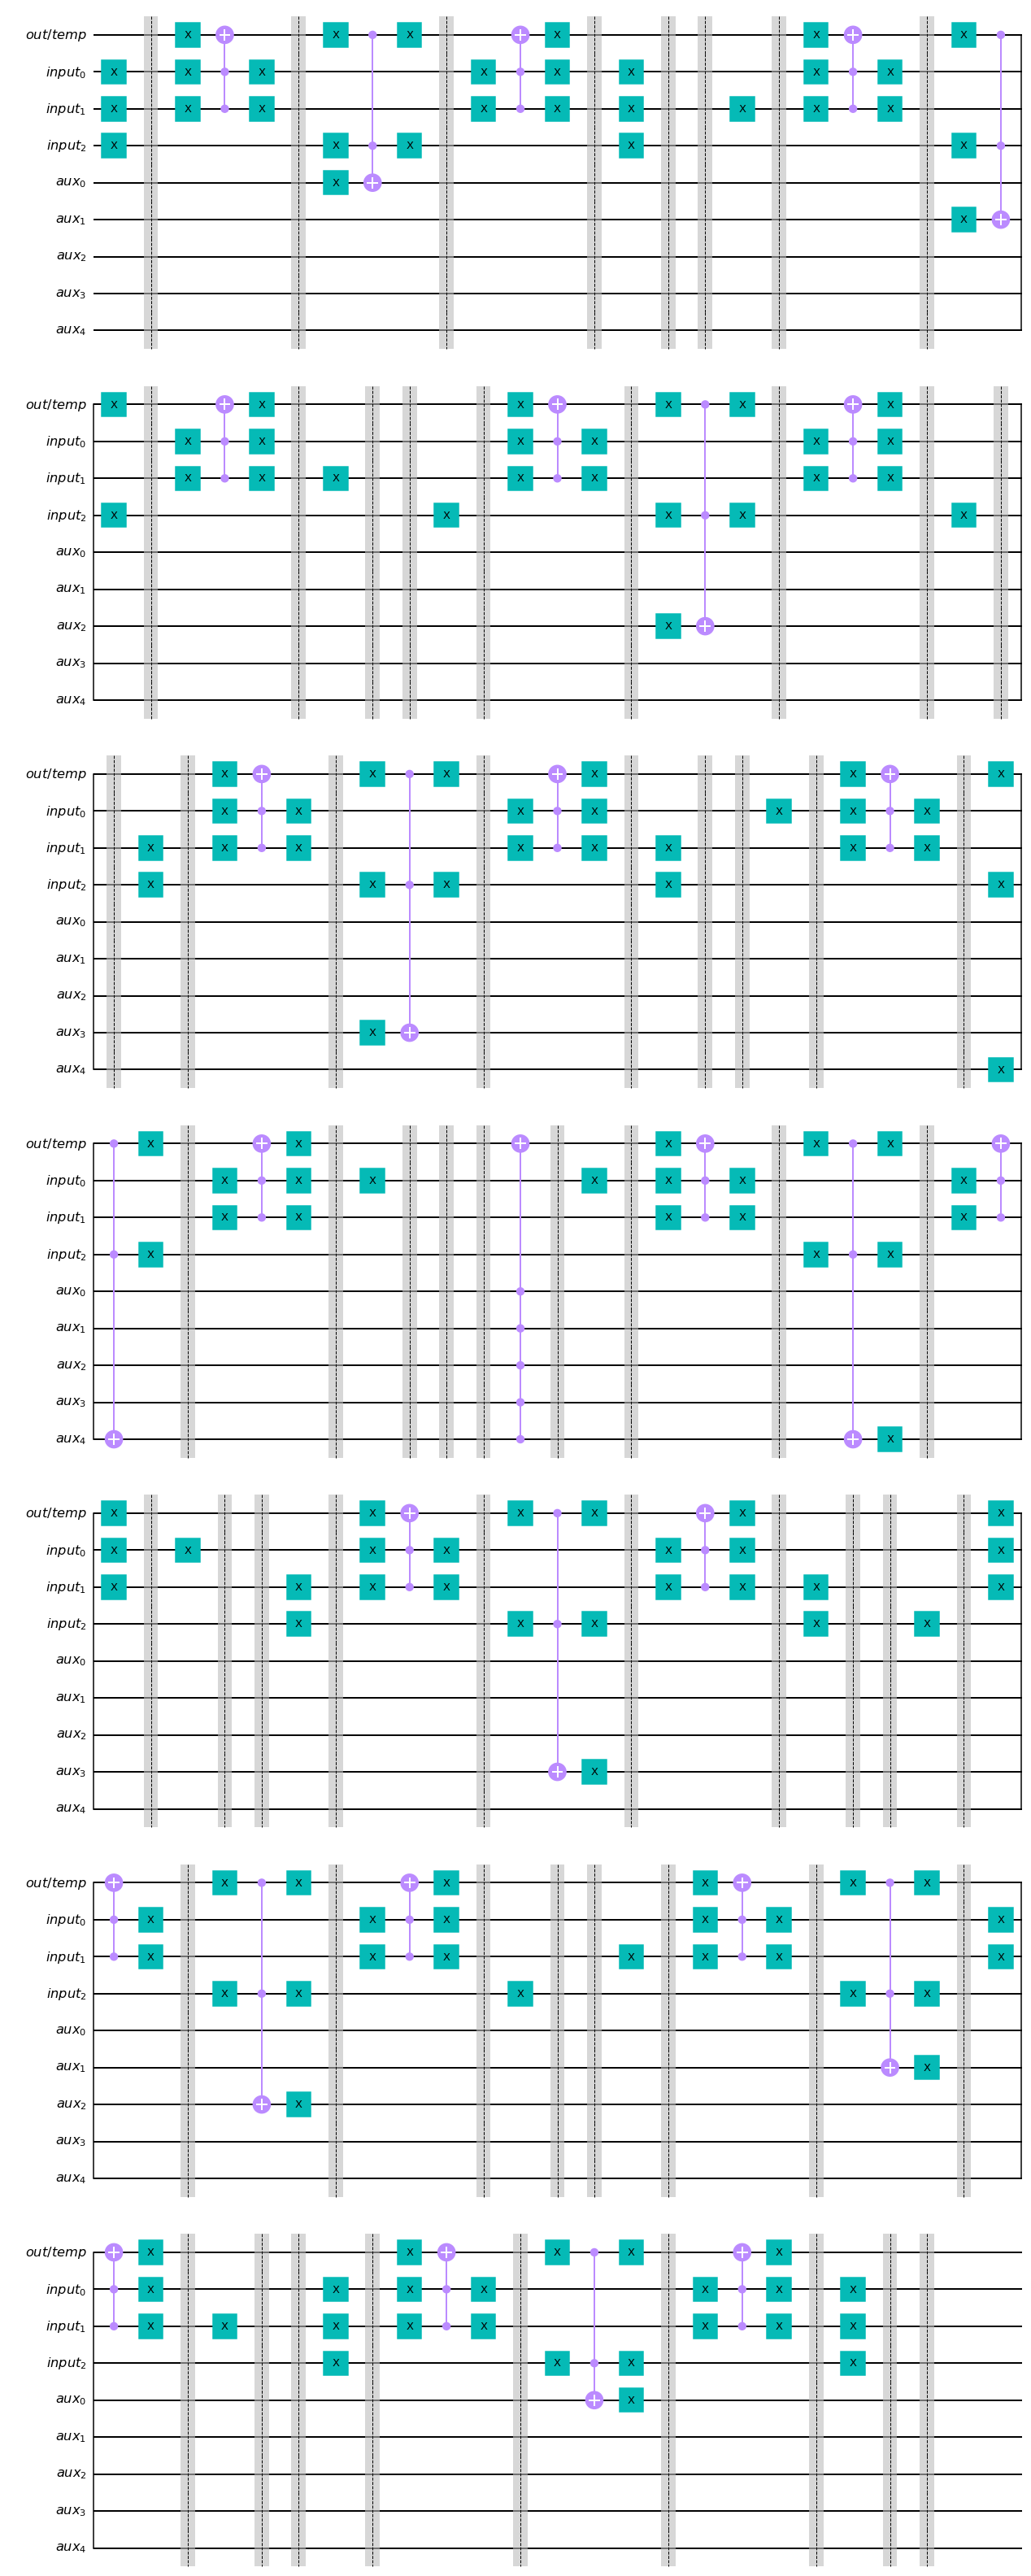

In [ ]:
##runner file
num_clauses = len(real_input.split("&"))
clause_num = count_input(real_input)

aux = QuantumRegister(num_clauses,"aux")
input = QuantumRegister(clause_num, "input")
temp = QuantumRegister(1, "out/temp")
qc = QuantumCircuit(temp, input, aux)

print(qubit_dict)

parsed = parse_real(real_input)
if len(parsed) != num_clauses: # VALIDATES INPUT
  raise Exception("inavlid input")

for i in range(len(parsed)):
  apply_clause(parsed[i], qc, aux, input, temp, i)
  qc.barrier()
  qc.barrier()

qc.barrier()

qc.mcx(aux, temp)

qc.barrier()

for i in range(len(parsed)):
  apply_clause_rev(parsed[len(parsed)-i-1], qc, aux, input, temp, len(parsed)-i-1)
  qc.barrier()
  qc.barrier()
oracle = qc
qc.draw('mpl')



### <font color=green>VALIDATING THE ORACLE</font>


Note: 
the last bit is the output and the remaining bits are the variables in reverse order


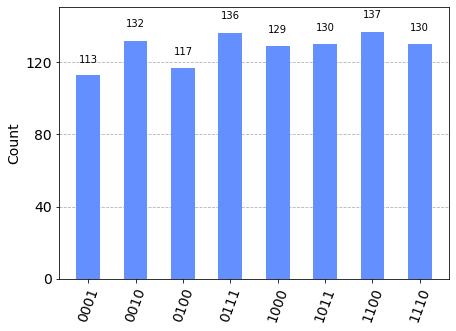

In [ ]:
#FOR VALIDATION PURPOSES
#Correct answers will have a 1 in the output bit
auxc = QuantumRegister(num_clauses,"aux")
inputc = QuantumRegister(clause_num, "input")
tempc = QuantumRegister(1, "out/temp")
cic = ClassicalRegister(clause_num+1, "classical")

qcc = QuantumCircuit(tempc,inputc,auxc,cic)
qcc.h(inputc)
#apply our oracle
qcc.compose(oracle,inplace=True)

for i in range((clause_num + 1)):
    qcc.measure(i, cic[i])

backend = Aer.get_backend('qasm_simulator')
counts= execute(qcc,backend, shots=1024).result().get_counts(qcc)
print("Note: \nthe last bit is the output and the remaining bits are the variables in reverse order")
plot_histogram(counts)


In [ ]:
#using above histgram, get all answers according to our oracle
quantum_answers = set()
for bitstring, count in counts.items():
  if bitstring[-1] == '1':
    temporary = bitstring[0:len(bitstring)-1]
    quantum_answers.add(temporary[::-1])
print(quantum_answers)


{'101', '000', '110'}


In [ ]:
#Runner for the clasical solver
#global set to store classicaly calculated answers
classical_answers = set()
temp = real_input.split(" & ")
variables=set()
var_index = {}
clauses=[]
counter = 0
for var in temp:
  strs = var[1:len(var)-1]
  clauses.append(strs)
  vars = strs.split(" | ")
  for i in vars:
    var_name = i
    if(i[0]=='!'):
      var_name = i[1:len(i)]
    variables.add(var_name)
    if var_name not in var_index:
      var_index[var_name] = counter
      counter+=1
print(clauses)
var_list = [False for x in range(len(variables))]
num_solutions = bool_recurse(len(variables),0,var_list,clauses)
print(classical_answers)



['!v_1 | !v_2 | !v_3', 'v_1 | !v_2 | v_3', 'v_1 | v_2 | !v_3', 'v_1 | !v_2 | !v_3', '!v_1 | v_2 | v_3']
{'101', '000', '110'}


In [ ]:
#Validate Oracle
correct = True
print("classical_answers:")
print(classical_answers)
print("quantum_answers:")
print(quantum_answers)
if len(quantum_answers) != len(classical_answers):
  correct = False
for bit in quantum_answers:
  if bit not in classical_answers:
    correct = False
if correct:
  print("----ORACLE VALIDATED----")
else:
  print("----INCORRECT----")


classical_answers:
{'101', '000', '110'}
quantum_answers:
{'101', '000', '110'}
----ORACLE VALIDATED----


### <font color=orange>GROVERS</font>

In [ ]:
input = clause_num
output = 1
aux = num_clauses

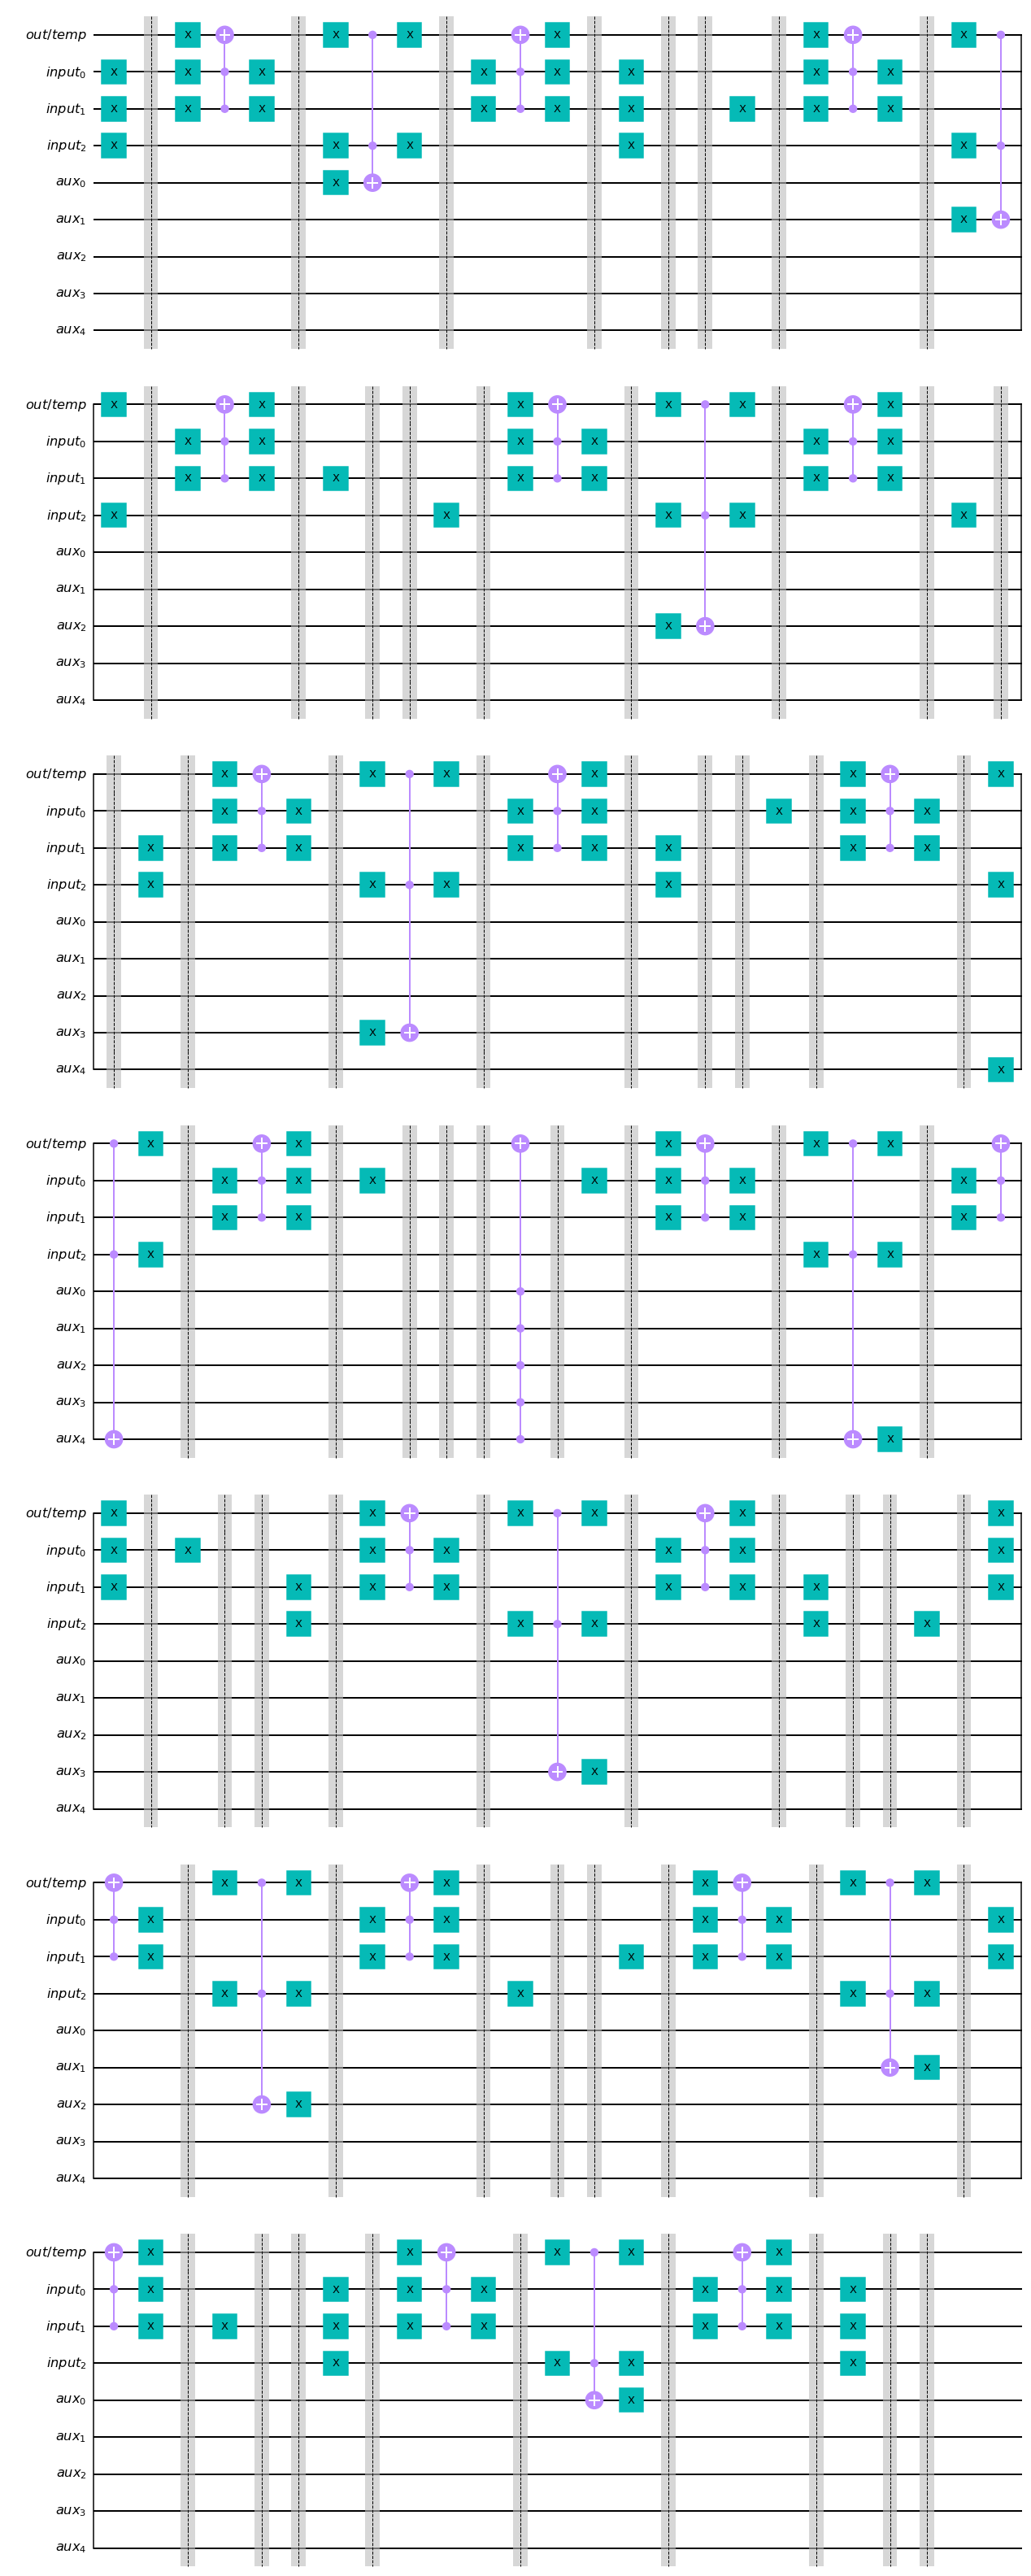

In [ ]:
#create oracle circuit
oq = QuantumRegister(output,'output')
iq = QuantumRegister(input,'input')
aq = QuantumRegister(aux,'auxiliary')

U = QuantumCircuit(oq,iq,aq)

#apply oracle here
U = oracle

U.draw('mpl')

In [ ]:
def CCnZ(qc,qubits):
  n=len(qubits)

  qt=QuantumCircuit(2)
  qt.cz(0,1)

  bigCZ=qt.to_gate(label='CZ').control(n-2)

  qc.append(bigCZ,qubits)

  return qc

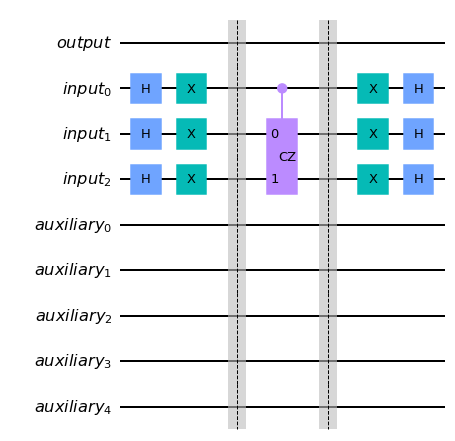

In [ ]:
#create diffuser circuit
oqd = QuantumRegister(output,'output')
iqd = QuantumRegister(input,'input')
aqd = QuantumRegister(aux,'auxiliary')
W = QuantumCircuit(oqd,iqd,aqd)

W.h(iqd)

W.x(iqd)

W.barrier()
# W.h(1)
# W.ccx(iqd[1],iqd[2],iqd[0])
# W.h(1)
CCnZ(W,iqd)
# #W.mcx(iqd, oqd)
W.barrier()

W.x(iqd)
W.h(iqd)

W.draw('mpl')

In [ ]:
#Calculate number of iterations needed
n=input
M= num_solutions #classical calculated solutions
R = int(np.floor(np.pi*(np.sqrt((2**n)/M))/4))
print(R)

1


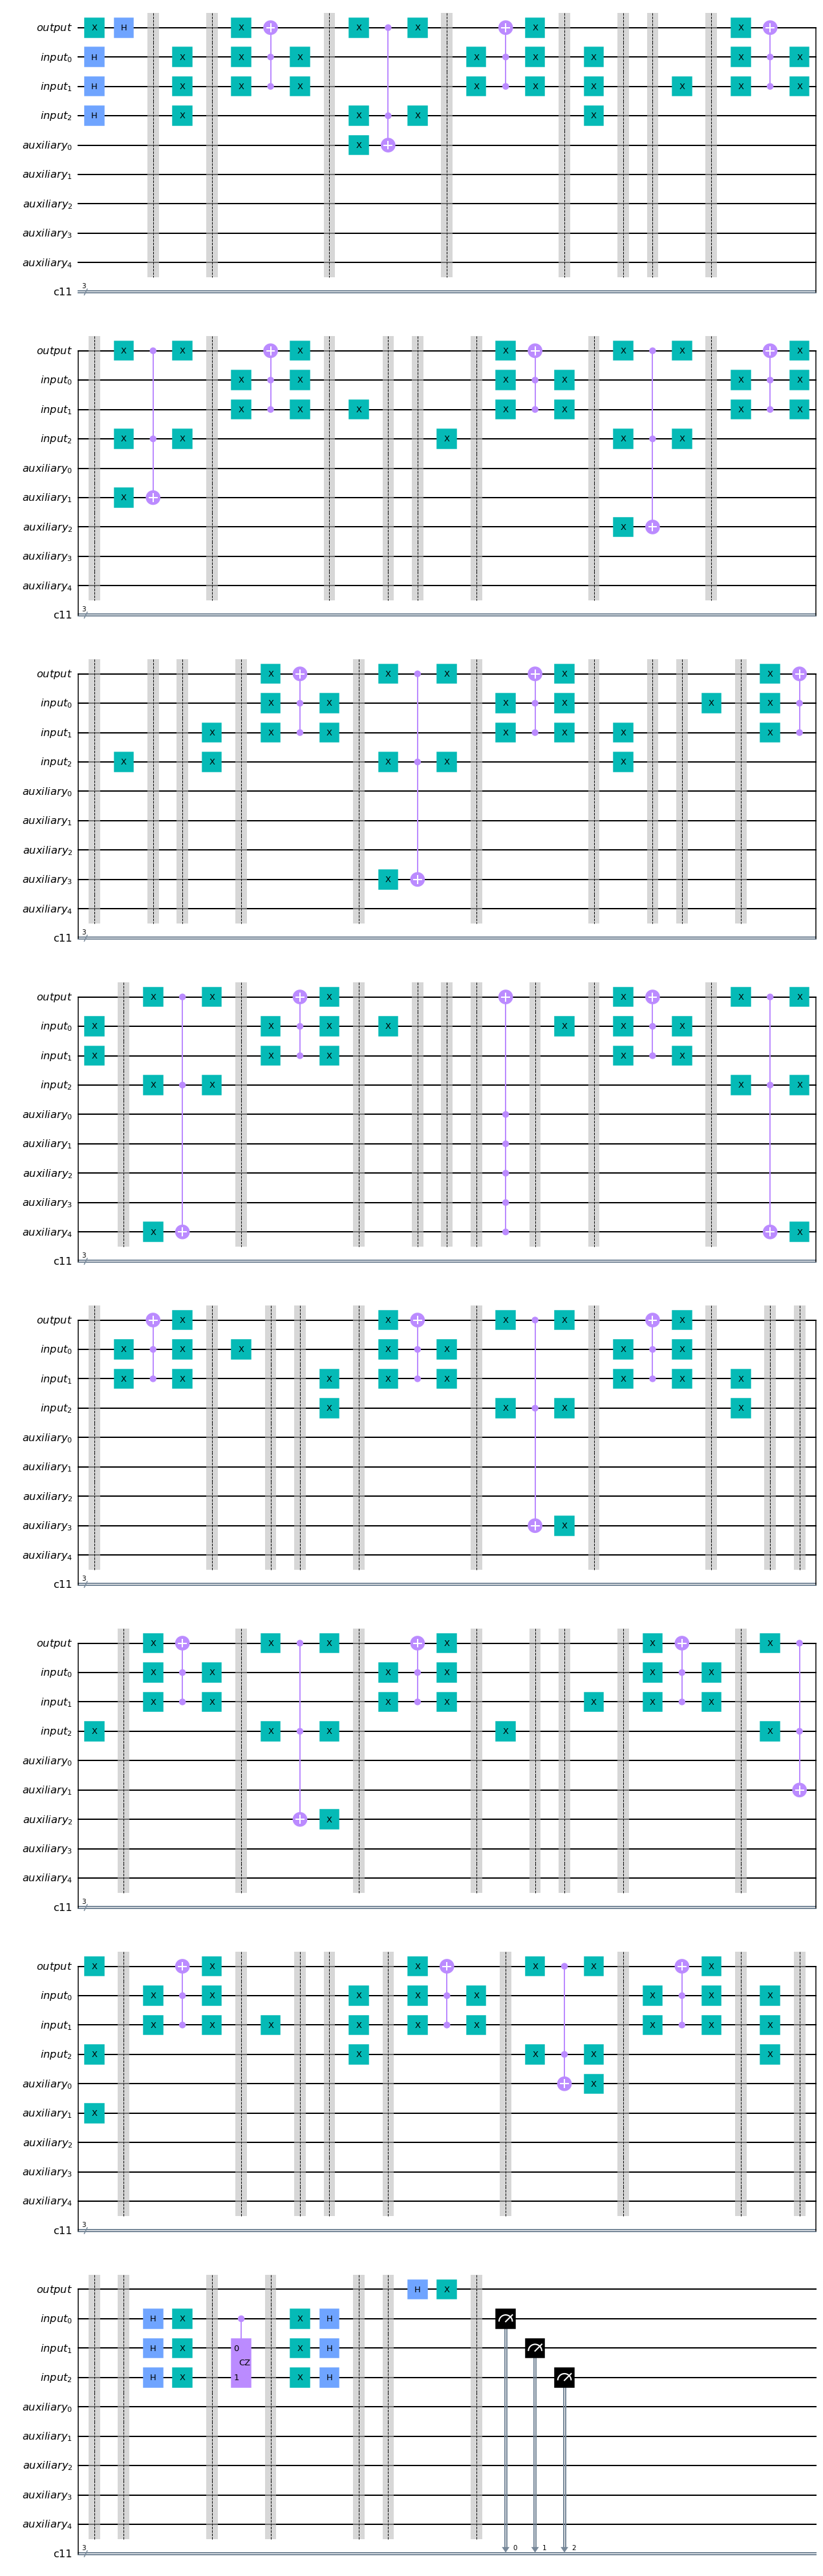

In [ ]:
#Actually run grovers
oqqc = QuantumRegister(output,'output')
iqqc = QuantumRegister(input,'input')
aqqc = QuantumRegister(aux,'auxiliary')
ci = ClassicalRegister(input)
qc = QuantumCircuit(oqqc,iqqc,aqqc,ci)


qc.x(oqqc)

qc.h(oqqc)
qc.h(iqqc)

qc.barrier()

for i in range(R):
    qc.compose(U,inplace=True)
    qc.barrier()
    qc.compose(W,inplace=True)
    qc.barrier()

qc.barrier()

qc.h(0)

qc.x(0)

qc.barrier()

for i in range(n):
    qc.measure(i+1,i)
    
qc.draw('mpl')

{'010': 83, '101': 204, '001': 100, '011': 193, '000': 183, '111': 110, '110': 87, '100': 64}


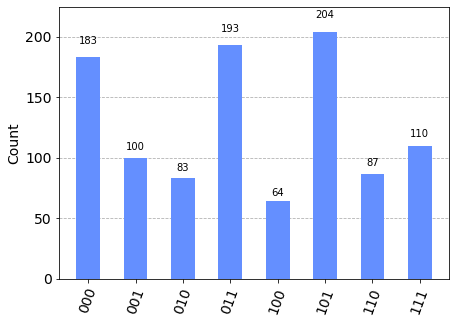

In [ ]:
#the Mth highest peaks will be your answers
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
result = job.result()
counts=result.get_counts(qc)
print(counts)
plot_histogram(counts)